### We will be testing a number of different individual and ensemble classification methods with increasing complexity

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

#----------------------------------
from matplotlib.colors import ListedColormap
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

#----------------------------------


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from functools import partial

from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
import xgboost as xgb

import optuna

In [2]:
data = pd.read_csv("clean_data.csv")

In [3]:
data = data.drop('Unnamed: 0',axis=1)

# Preparing data for ML

In [4]:
X0, y0 = data.drop('activity',axis=1), data['activity']
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first',sparse=False)
Xe = ohe.fit_transform(X0[['gender','device']])
Xs = scaler.fit_transform(X0.drop(['gender','device'],axis=1))
X = np.concatenate([Xs, Xe], axis=1)
lb = LabelEncoder()
y = lb.fit_transform(y0)

# Individual ML models

## Gaussian Naive Bayes Classifier

In [5]:
gnb = GaussianNB()
kf = StratifiedKFold(n_splits=5, shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    gnb.fit(xtrain,ytrain)
    preds=gnb.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

GNB_acc = np.mean(accs)

In [6]:
All_Accuracies = {'Gaussian Naive Bayes': GNB_acc}
GNB_acc

0.26468641394837694

## Decision Tree Classifier

In [7]:
dtree = DecisionTreeClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    dtree.fit(xtrain,ytrain)
    preds=dtree.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

np.mean(accs)

0.773787893082162

## Hyperparameter optimization to get the best decision tree

In [8]:
study_dtree = optuna.create_study(direction='minimize')

[I 2020-09-11 17:45:19,004] A new study created in memory with name: no-name-3e920954-e022-477c-bbfd-a6a5347cab62


In [9]:
def objective_fn_tree(trial, x, y):
   

    criterion = trial.suggest_categorical('criterion',['gini','entropy'])
    max_depth = trial.suggest_int('max_depth',1,20)
    
    model = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth)
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    accs = []
    for idx in kf.split(X=x, y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain,ytrain)
        preds=model.predict(xtest)
        acc = accuracy_score(ytest,preds)
        accs.append(acc)
        
    return -np.mean(accs)

In [10]:
optimize_dtree = partial(objective_fn_tree,x=X,y = y)
study_dtree.optimize(optimize_dtree,n_trials=25)

[I 2020-09-11 17:45:20,295] Trial 0 finished with value: -0.7629316477514669 and parameters: {'criterion': 'gini', 'max_depth': 18}. Best is trial 0 with value: -0.7629316477514669.
[I 2020-09-11 17:45:20,867] Trial 1 finished with value: -0.7393059213797428 and parameters: {'criterion': 'entropy', 'max_depth': 14}. Best is trial 0 with value: -0.7629316477514669.
[I 2020-09-11 17:45:20,977] Trial 2 finished with value: -0.3674961561900002 and parameters: {'criterion': 'gini', 'max_depth': 3}. Best is trial 0 with value: -0.7629316477514669.
[I 2020-09-11 17:45:21,527] Trial 3 finished with value: -0.7270101915148054 and parameters: {'criterion': 'entropy', 'max_depth': 13}. Best is trial 0 with value: -0.7629316477514669.
[I 2020-09-11 17:45:21,854] Trial 4 finished with value: -0.7479219202986316 and parameters: {'criterion': 'gini', 'max_depth': 17}. Best is trial 0 with value: -0.7629316477514669.
[I 2020-09-11 17:45:22,145] Trial 5 finished with value: -0.48243678430552617 and par

In [11]:
DTREE_acc = -study_dtree.best_value

In [12]:
All_Accuracies['Decision Tree'] =  DTREE_acc
DTREE_acc

0.7857603094426412

## K-Neighbors Classifier

In [13]:
kneighbors = KNeighborsClassifier()
kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    kneighbors.fit(xtrain,ytrain)
    preds=kneighbors.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

np.mean(accs)

0.6781605297445875

## Hyperparameter optimization to get the best K-Neighbors classifier

In [14]:
study_kneighbors = optuna.create_study(direction='minimize')

[I 2020-09-11 17:48:47,972] A new study created in memory with name: no-name-6d3b1f78-783c-4424-a274-0799f043966d


In [15]:
def objective_fn_kneighbors(trial, x, y):
    
    n_neighbors = trial.suggest_int('n_neighbors',2,10)
    p = trial.suggest_int('p',1,3)
    
    model = KNeighborsClassifier(n_neighbors = n_neighbors, p=p)
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    accs = []
    for idx in kf.split(X=x, y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain,ytrain)
        preds=model.predict(xtest)
        acc = accuracy_score(ytest,preds)
        accs.append(acc)
        
    return -np.mean(accs)

In [16]:
optimize_kneighbors = partial(objective_fn_kneighbors,x=X,y = y)
study_kneighbors.optimize(optimize_kneighbors,n_trials=25)

[I 2020-09-11 17:48:49,921] Trial 0 finished with value: -0.6736911285120184 and parameters: {'n_neighbors': 5, 'p': 2}. Best is trial 0 with value: -0.6736911285120184.
[I 2020-09-11 17:48:50,404] Trial 1 finished with value: -0.7600600730770114 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 1 with value: -0.7600600730770114.
[I 2020-09-11 17:48:50,945] Trial 2 finished with value: -0.7321221400906196 and parameters: {'n_neighbors': 4, 'p': 1}. Best is trial 1 with value: -0.7600600730770114.
[I 2020-09-11 17:48:51,676] Trial 3 finished with value: -0.5919587239825697 and parameters: {'n_neighbors': 10, 'p': 1}. Best is trial 1 with value: -0.7600600730770114.
[I 2020-09-11 17:48:52,421] Trial 4 finished with value: -0.6187742389511179 and parameters: {'n_neighbors': 9, 'p': 1}. Best is trial 1 with value: -0.7600600730770114.
[I 2020-09-11 17:48:53,332] Trial 5 finished with value: -0.6607612656142829 and parameters: {'n_neighbors': 7, 'p': 1}. Best is trial 1 with value: 

In [17]:
KN_acc = -study_kneighbors.best_value

In [18]:
All_Accuracies['K-Neighbors'] = KN_acc
KN_acc

0.763728584942464

## Random Forest Classifier

In [19]:
rforest = RandomForestClassifier()
kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    rforest.fit(xtrain,ytrain)
    preds=rforest.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

np.mean(accs)

0.8644652195752558

## Hyperparameter optimization to get the best random forest

In [20]:
study_rforest = optuna.create_study(direction='minimize')

[I 2020-09-11 17:51:30,847] A new study created in memory with name: no-name-ee490104-9330-413e-9517-c6a88ffc40ea


In [21]:
def objective_fn_random_forest(trial, x, y):
   

    criterion = trial.suggest_categorical('criterion',['gini','entropy'])
    max_features = trial.suggest_categorical('max_features',['sqrt', 'log2'])
    max_samples=trial.suggest_uniform('max_samples',0.2,0.8)
    
    model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_samples=max_samples)
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    accs = []
    for idx in kf.split(X=x, y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain,ytrain)
        preds=model.predict(xtest)
        acc = accuracy_score(ytest,preds)
        accs.append(acc)
        
    return -np.mean(accs)

In [22]:
optimize_rforest = partial(objective_fn_random_forest,x=X,y = y)
study_rforest.optimize(optimize_rforest,n_trials=25)

[I 2020-09-11 17:51:36,637] Trial 0 finished with value: -0.8368462654485465 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_samples': 0.3286001854760496}. Best is trial 0 with value: -0.8368462654485465.
[I 2020-09-11 17:51:41,699] Trial 1 finished with value: -0.8617470148321346 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_samples': 0.6817287996024707}. Best is trial 1 with value: -0.8617470148321346.
[I 2020-09-11 17:51:45,091] Trial 2 finished with value: -0.8425947693586512 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_samples': 0.34822040532954346}. Best is trial 1 with value: -0.8617470148321346.
[I 2020-09-11 17:51:51,628] Trial 3 finished with value: -0.8491377881582605 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_samples': 0.46507840387465954}. Best is trial 1 with value: -0.8617470148321346.
[I 2020-09-11 17:51:55,180] Trial 4 finished with value: -0.8384438370275555 and parameters: {'crit

In [23]:
RForest_acc = -study_rforest.best_value

In [24]:
All_Accuracies['Random Forest'] = RForest_acc
RForest_acc

0.8620673960768915

## Best of each individual classifier for ensemble methods (voters and adaptative boosting)
Gaussian Naive Bayes does not have tunable hyperparameters that we could use to improve performance.

In [25]:
GNB = GaussianNB()
DTREE = DecisionTreeClassifier(**study_dtree.best_params)
KN = KNeighborsClassifier(**study_kneighbors.best_params)

## Hard voting classifier

In [26]:
votingC_hard = VotingClassifier(estimators=[('GNB', GNB), ('DTREE', DTREE), ('KN', KN)],\
                                voting='hard')

kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    votingC_hard.fit(xtrain,ytrain)
    preds=votingC_hard.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

VCH_acc = np.mean(accs)

In [27]:
All_Accuracies['Unweighted Voting'] = VCH_acc
VCH_acc

0.7573454380413526

## Soft voting classifier 
We calculate weights according to previous performance of each individual model.

In [28]:
estimator_accs = [GNB_acc,DTREE_acc,KN_acc]
norm_acc = np.linalg.norm(estimator_accs,ord=1)
weights = [est/norm_acc for est in estimator_accs]

In [29]:
votingC_soft = VotingClassifier(estimators=[('GNB', GNB), ('DTREE', DTREE), ('KN', KN)],\
                                voting='soft',weights=weights)

kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    votingC_soft.fit(xtrain,ytrain)
    preds=votingC_soft.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

VCS_acc = np.mean(accs)

In [30]:
All_Accuracies['Weighted Voting'] = VCS_acc
VCS_acc

0.8022040393789729

## Adaptative Boosting

In [31]:
adaboost1 = AdaBoostClassifier()
kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    adaboost1.fit(xtrain,ytrain)
    preds=adaboost1.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

np.mean(accs)

0.4913776266034999

### Changing base estimators for adaptative boosting
1.- Gaussian Naive Bayes

In [32]:
adaboost2 = AdaBoostClassifier(base_estimator = GNB)

kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    adaboost2.fit(xtrain,ytrain)
    preds=adaboost2.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

ada_acc = np.mean(accs)

In [33]:
All_Accuracies['Adaptative Boosting (GNB)'] = ada_acc
ada_acc

0.24585493218830717

2.- Decission Tree as base estimator

In [34]:
adaboost3 = AdaBoostClassifier(base_estimator = DTREE)

kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    adaboost3.fit(xtrain,ytrain)
    preds=adaboost3.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

ada_acc2 = np.mean(accs)

In [35]:
All_Accuracies['Adaptative Boosting (DT)'] = ada_acc2
ada_acc2

0.8090712641099062

## Extreme Gradient Boosting Classifier

In [36]:
kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    boost = xgb.XGBClassifier().fit(xtrain,ytrain)
    preds = boost.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

np.mean(accs)

0.8614303307843922

### Hyperparameter optimization for xgboost
We first do hyperparameter optimization on 5 estimators on the booster, and then increase the number of estimators. This approach showed to be more efficient both in running time (about 1/10th of that of more estimators in the hyperparameter optimization process) and in accuracy on the predictions.

In [37]:
study_xgb = optuna.create_study(direction='minimize')

[I 2020-09-11 17:54:47,637] A new study created in memory with name: no-name-e64aeaa6-55d4-4312-bf93-ee30471e7881


In [38]:
def objective_fn_xgb(trial, x, y):
   

    eta = trial.suggest_uniform('eta',0.1,1.0)
    max_depth = trial.suggest_int('max_depth',2,10)
    subsample = trial.suggest_uniform('max_samples',0.1,1.0)
    
    model = xgb.XGBClassifier(eta = eta, max_depth = max_depth, subsample = subsample, \
                              n_estimators = 5, objective = 'multi:softmax')
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    accs = []
    for idx in kf.split(X=x, y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        boost = model.fit(xtrain,ytrain)
        preds=boost.predict(xtest)
        acc = accuracy_score(ytest,preds)
        accs.append(acc)
        
    return -np.mean(accs)

In [39]:
optimize_xgb = partial(objective_fn_xgb,x=X,y = y)
study_xgb.optimize(optimize_xgb,n_trials=25)

[I 2020-09-11 17:54:50,042] Trial 0 finished with value: -0.7405832392035473 and parameters: {'eta': 0.17587698876701996, 'max_depth': 8, 'max_samples': 0.9538865619527387}. Best is trial 0 with value: -0.7405832392035473.
[I 2020-09-11 17:54:50,966] Trial 1 finished with value: -0.7145570120528622 and parameters: {'eta': 0.4576817748014338, 'max_depth': 6, 'max_samples': 0.7881162980470449}. Best is trial 0 with value: -0.7405832392035473.
[I 2020-09-11 17:54:51,698] Trial 2 finished with value: -0.643520598486954 and parameters: {'eta': 0.9414119333853134, 'max_depth': 4, 'max_samples': 0.32286675533554465}. Best is trial 0 with value: -0.7405832392035473.
[I 2020-09-11 17:54:52,308] Trial 3 finished with value: -0.5451789825823774 and parameters: {'eta': 0.6853526585995019, 'max_depth': 2, 'max_samples': 0.8674916087599777}. Best is trial 0 with value: -0.7405832392035473.
[I 2020-09-11 17:54:53,289] Trial 4 finished with value: -0.6369727350843599 and parameters: {'eta': 0.17183297

Take the best XGBClassifier (on 5 estimators) and increase the estimator number. 100 estimators proved to be sufficient. Increasing number of estimators beyond 100 will take longer to run and no real increase in accuracy.

In [40]:
kf = StratifiedKFold(n_splits=5,shuffle=True)
accs = []
for idx in kf.split(X=X, y=y):
    train_idx,test_idx = idx[0],idx[1]
    xtrain = X[train_idx]
    ytrain = y[train_idx]
    xtest = X[test_idx]
    ytest = y[test_idx]
        
    boost = xgb.XGBClassifier(**study_xgb.best_params, n_estimators = 100).fit(xtrain,ytrain)
    preds = boost.predict(xtest)
    acc = accuracy_score(ytest,preds)
    accs.append(acc)

XGB_acc = np.mean(accs)

[17:55:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but

In [41]:
All_Accuracies['Gradient Boosting'] = XGB_acc
XGB_acc

0.8647834334976248

### Segmenting data by device:
We train and test our top performing xgboost classifier for the data from apple watch and fitbit. There seems to be no significant difference between accuracy for fitbit and apple watch, unlike the original study.

In [42]:
XGB_C_acc=[]
for device in data['device'].unique():
    A0, b0 = data[data['device'] == device]\
    .drop('activity',axis=1),data[data['device'] == device]['activity']
    Ae = ohe.fit_transform(A0[['gender']])
    As = scaler.fit_transform(A0.drop(['gender','device'],axis=1))
    A = np.concatenate([As, Ae], axis=1)
    lb = LabelEncoder()
    b = lb.fit_transform(b0)
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    for idx in kf.split(X=A, y=b):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = X[train_idx]
        ytrain = y[train_idx]
        xtest = X[test_idx]
        ytest = y[test_idx]
        
        boost = xgb.XGBClassifier(**study_xgb.best_params, n_estimators = 100).fit(xtrain,ytrain)
        preds = boost.predict(xtest)
        acc = accuracy_score(ytest,preds)
        XGB_C_acc.append((device,acc))

[17:55:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:55:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but

#### Results

In [43]:
XGB_C_acc

[('apple watch', 0.8469945355191257),
 ('apple watch', 0.8399452804377565),
 ('apple watch', 0.8454172366621067),
 ('apple watch', 0.8290013679890561),
 ('apple watch', 0.811217510259918),
 ('fitbit', 0.8582375478927203),
 ('fitbit', 0.8409961685823755),
 ('fitbit', 0.8084291187739464),
 ('fitbit', 0.8406909788867563),
 ('fitbit', 0.8464491362763915)]

In [44]:
apple_watch = [result[1] for result in XGB_C_acc if result[0]=='apple watch']
fitbit = [result[1] for result in XGB_C_acc if result[0]=='fitbit']

In [45]:
(np.mean(apple_watch),np.mean(fitbit))

(0.8345151861735924, 0.838960590082438)

In [46]:
All_Accuracies

{'Gaussian Naive Bayes': 0.26468641394837694,
 'Decision Tree': 0.7857603094426412,
 'K-Neighbors': 0.763728584942464,
 'Random Forest': 0.8620673960768915,
 'Unweighted Voting': 0.7573454380413526,
 'Weighted Voting': 0.8022040393789729,
 'Adaptative Boosting (GNB)': 0.24585493218830717,
 'Adaptative Boosting (DT)': 0.8090712641099062,
 'Gradient Boosting': 0.8647834334976248}

In [47]:
ACC = pd.DataFrame.from_dict(All_Accuracies, orient='index')

In [48]:
ACC.reset_index(inplace=True)

In [49]:
ACC.columns = ['Method', 'accuracy']

In [50]:
ACC['complexity'] = [0,0,0,2,1,1,2,2,3]

In [51]:
ACC

,Method,accuracy,complexity
0,Gaussian Naive Bayes,0.264686,0
1,Decision Tree,0.785760,0
2,K-Neighbors,0.763729,0
3,Random Forest,0.862067,2
4,Unweighted Voting,0.757345,1
5,Weighted Voting,0.802204,1
6,Adaptative Boosting (GNB),0.245855,2
7,Adaptative Boosting (DT),0.809071,2
8,Gradient Boosting,0.864783,3


In [52]:
ACC['worst'] = [0.2656422031214542,0.7702747909808791,0.67736244514762,\
                0.8601539053874534,0.748245,0.796937,0.4944165950600349,0.4944165950600349,0.8650989701393972]

In [53]:
ACC

,Method,accuracy,complexity,worst
0,Gaussian Naive Bayes,0.264686,0,0.265642
1,Decision Tree,0.785760,0,0.770275
2,K-Neighbors,0.763729,0,0.677362
3,Random Forest,0.862067,2,0.860154
4,Unweighted Voting,0.757345,1,0.748245
5,Weighted Voting,0.802204,1,0.796937
6,Adaptative Boosting (GNB),0.245855,2,0.494417
7,Adaptative Boosting (DT),0.809071,2,0.494417
8,Gradient Boosting,0.864783,3,0.865099


In [66]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style("whitegrid", {"axes.facecolor": ".95", 'axes.labelcolor': '.25',\
                          'figure.facecolor': 'white', 'text.color': '.25',\
                           'font.family': ['DejaVu Sans'],})

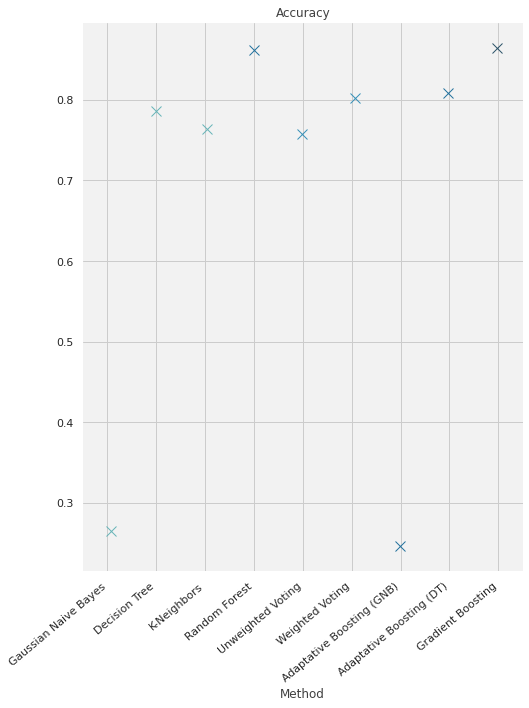

In [67]:
g = sns.PairGrid(ACC,
                 x_vars='Method', y_vars="accuracy", hue='complexity',
                 height=10, aspect=.75)

g.map(sns.stripplot, size=10, orient="v", marker = 'x',
      palette="YlGnBu_d", linewidth=1, edgecolor="w")

g.set(xlabel="Method", ylabel="")

titles = ["Accuracy"]

for ax, title in zip(g.axes.flat, titles):
    
    ax.set(title=title)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.savefig('img/accs.png', dpi=500)
plt.show()

## Visualization:
This next set of plots helps understand the interaction between some main variables (y-axis) and predictions on activity state.

In [56]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2,stratify=y,shuffle=True)
        
boost = xgb.XGBClassifier(**study_xgb.best_params, n_estimators = 100).fit(xtrain,ytrain)
preds = boost.predict(xtest)

[17:57:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [57]:
dftrain = pd.DataFrame(xtrain, columns = list(data.columns[:-1]))
dftrain['True activity state'] = ytrain
dftrain

,age,gender,height,weight,steps,heart_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,True activity state
0,-0.803582,-0.165544,-0.566097,-0.235938,2.246647,-0.690717,-0.299699,0.058588,0.328838,-0.456101,0.894497,2.607905,2.415923,2.921069,-0.144290,0.0,0.0,5
1,-1.140348,0.996811,-0.514056,-0.475516,1.712867,2.106674,-0.192168,0.333225,0.434164,0.639734,-1.684964,1.250755,1.438203,-0.397606,-0.140736,1.0,1.0,4
2,-0.803582,-0.165544,-0.566097,1.179808,-0.842779,0.010124,-0.295735,0.058588,0.328838,-0.456101,-1.637776,-0.509845,-0.543251,-0.449279,-0.122554,0.0,0.0,0
3,-0.242306,0.609359,0.905934,-0.388555,-1.076543,-0.253315,-0.300731,0.308907,0.419346,-0.467640,0.770665,-0.737134,-0.759735,0.011056,-0.145103,1.0,0.0,4
4,-0.579072,-0.456132,-1.978652,3.150560,0.361573,-0.710822,-0.301044,0.136791,0.358082,0.501387,0.708357,-0.009596,0.056349,-0.177023,-0.144553,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,-0.130051,0.609359,0.177353,1.070283,-0.214421,-0.685371,-0.297809,0.493791,0.400039,-0.092130,-0.063309,-0.147576,-0.141815,0.158074,-0.132198,1.0,0.0,4
5007,3.013097,-0.552995,-0.566097,-0.468376,-0.236863,-0.703827,-0.301029,-0.371526,0.134891,-0.041032,-0.392279,-0.208387,-0.049584,0.086800,-0.145198,1.0,0.0,2
5008,-1.252603,1.025870,1.515563,-0.137186,0.409573,-0.685371,-0.299795,0.208370,0.197189,0.619304,0.063178,-0.049229,-0.009598,-0.122054,-0.144025,1.0,0.0,2
5009,-0.803582,1.481125,0.727506,-0.446835,-0.310334,-0.639816,0.040457,0.333225,0.434164,0.462097,0.894497,-0.658319,-0.675736,-0.641554,-0.106525,1.0,1.0,1


In [58]:
dftest = pd.DataFrame(xtest, columns = list(data.columns[:-1]))
dftest['True activity state'] = ytest
dftest['Predicted activity state'] = preds

In [59]:
sns.set(rc={'figure.figsize':(15,15)})

In [64]:
palette='crest'
cols = ['heart_rate','calories','steps']

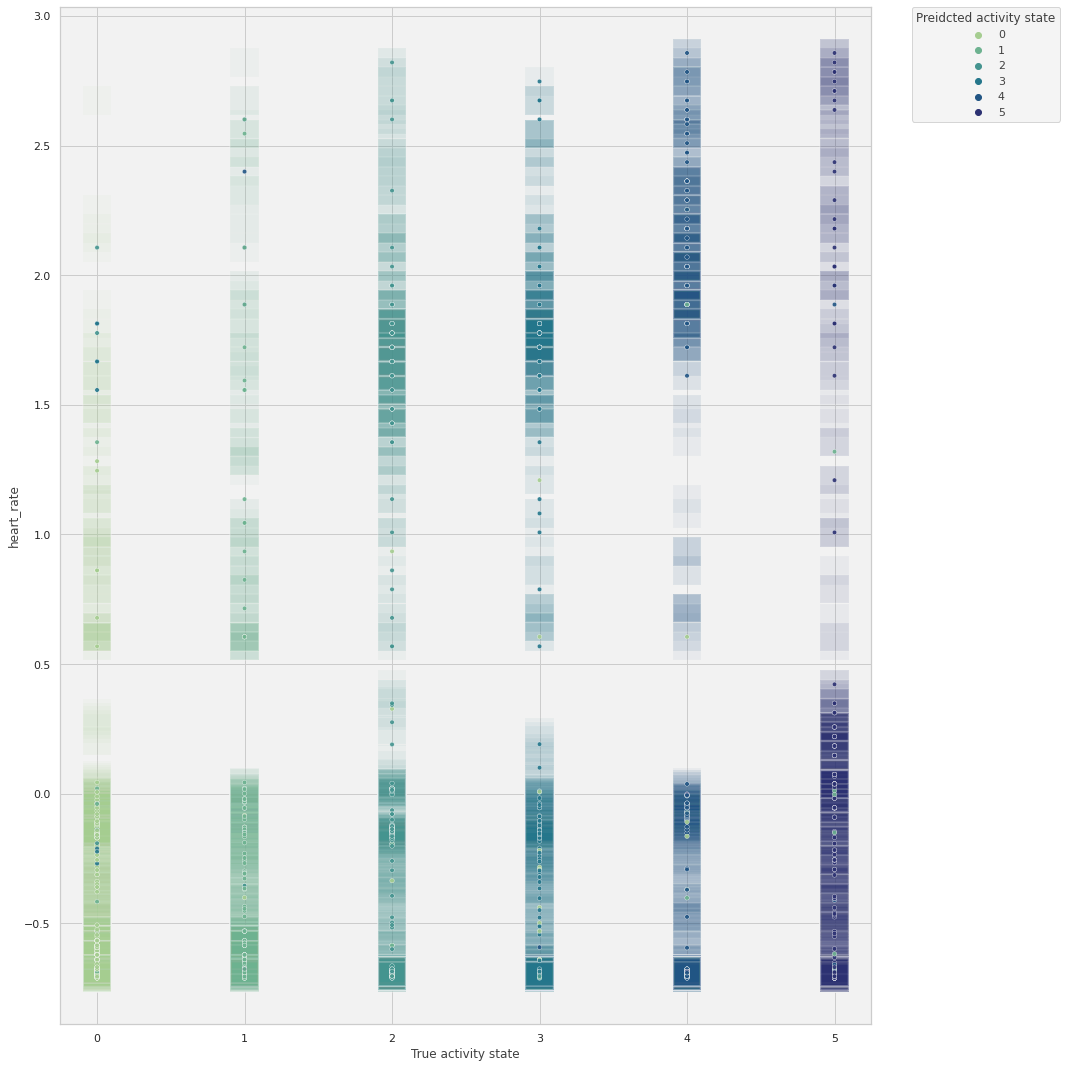

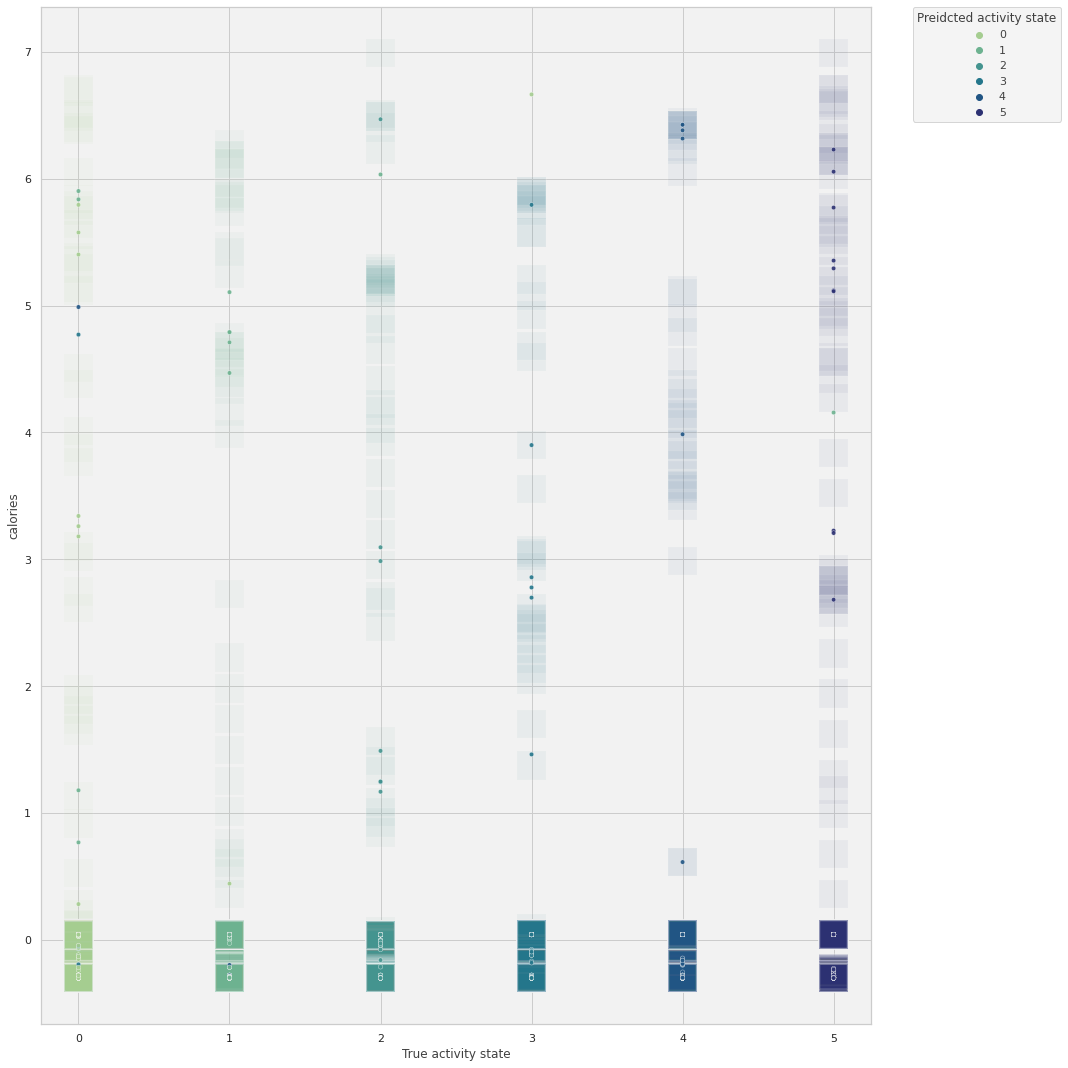

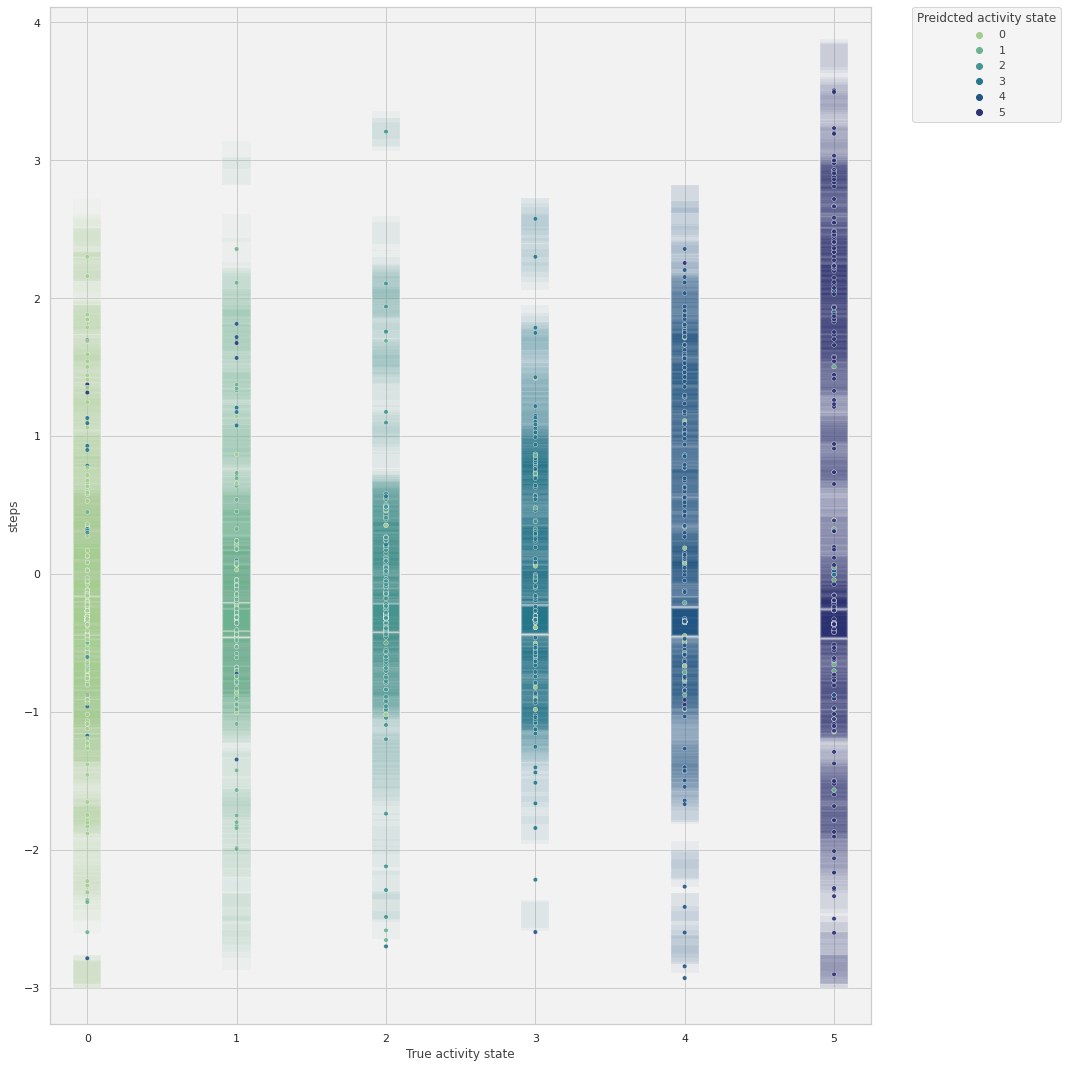

In [65]:
for col in cols:
    fig, ax = plt.subplots()

    sns.scatterplot(x='True activity state', y=col, data=dftrain, hue='True activity state',\
                marker='s',s=800,alpha=0.05, legend=False,ax=ax, palette=palette) 
    sns.scatterplot(x='True activity state', y=col, data=dftest, hue='Predicted activity state',\
                marker='o',s=20,alpha=0.9, ax=ax,palette=palette)
    plt.legend(title = 'Preidcted activity state',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    name = 'img/truevspredicted' + col +'.png'
    plt.tight_layout()
    plt.savefig(name, dpi=500)
    plt.show()